# Road sign classification (Train)

## by Yasin Shafiei

### project discription:
This project will train a CNN model to classify road signs from GTSRB dataset. The CNN model was built with `pytorch`

### 1. read and ready the training data

In [1]:
# import all librareis
import os
import numpy as np
import torch
from torchvision import transforms
from torch.utils import data as data
import torch.nn as nn
from torchsummary import summary
import torchvision
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb
%matplotlib inline

We should clear cache CUDA using `empty_cache()`

In [2]:
# clear cache
torch.cuda.empty_cache()

print("CUDA cache cleared!")

CUDA cache cleared!


In [3]:
# define hyperparameters
BATCH_SIZE = 256
EPOCHS = 22
NUM_CLASSES = 43
LEARNING_RATE = 0.001

Now we have to read the data and split the training and validation data. 
85 percent of data is for training and 15 percents for validation

In [4]:
# define the transforms
data_transforms = transforms.Compose([transforms.Resize([112, 112]), transforms.ToTensor()])
# define the trainind data directory 
train_data_dir = "data/Train"
# define training data
training_data = torchvision.datasets.ImageFolder(root = train_data_dir, transform = data_transforms)

# the training ratio
ratio = 0.8

# define number of training data and number of validation data
n_training = int(len(training_data) * ratio)
n_validation = len(training_data) - n_training

# split the training and the test data
training_data, validation_data = data.random_split(training_data, [n_training, n_validation])

In [5]:
# show the number of training samples and validation samples
print(f"Number of training samples: {len(training_data)}")
print(f"Number of validation samples: {len(validation_data)}")

Number of training samples: 31351
Number of validation samples: 7838


Now we splited the training and validaion data . Lets see a plot for training and validation data . I drew this plot using `matplotlib`

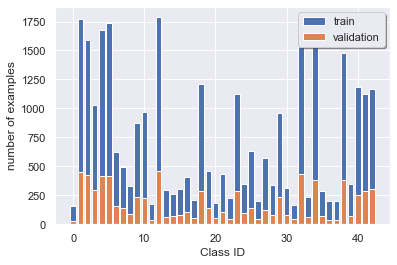

In [6]:
### training hist
training_hist = [0] * NUM_CLASSES

for i in training_data.indices:
    tar = training_data.dataset.targets[i]
    training_hist[tar] += 1
    
### validation hist
validation_hist = [0] * NUM_CLASSES

for i in validation_data.indices:
    tar = validation_data.dataset.targets[i]
    validation_hist[tar] += 1
    
# plot the bar graph
sb.set()
plt.bar(range(NUM_CLASSES), training_hist, label = "train")
plt.bar(range(NUM_CLASSES), validation_hist, label="validation")
legend = plt.legend(loc='upper right', shadow=True)
plt.xlabel("Class ID")
plt.ylabel("number of examples")

# save the plot
plt.savefig("train_val_data.png", bbox_inches = 'tight', pad_inches=0.5)

### 2. data loader 

In [7]:
# define the train and validation loader
train_loader = data.DataLoader(training_data, shuffle = True, batch_size = BATCH_SIZE)
validation_loader = data.DataLoader(validation_data, shuffle = True, batch_size = BATCH_SIZE)

### 3. Convolutional Neural Networks Model

In [8]:
def count_parameters(model):
    """
    This function will count the model trainable parameters
    """
    # model parameters calculation
    parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    return parameters 

The Convolutional Neural Networks model: 

In [9]:
class Model(nn.Module):
    # __init__
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            # input conv layer 
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            # conv layer 1
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            
            # conv layer 2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # conv layer 3
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # conv layer 4
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(inplace=True),
            )
    
        # classifier (hidden layers and neurons)
        self.classifier = nn.Sequential(
            
            # hidden layer 1
            nn.Dropout(0.3),
            nn.Linear(512*7*7, 1024),
            nn.ReLU(inplace=True),
            
            # hidden layer 2
            nn.Dropout(0.3),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
                        
    
            # output layer
            nn.Linear(512, output_dim)
            )
    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

Now we created our model. lets count the model parameters

In [10]:
# define a variable for the model
model = Model(NUM_CLASSES)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 30,148,779 trainable parameters


So we saw that the model has `20,449,579` trainable parameters. Now we have to define the optimizer and the loss function 

In [11]:
# define the optimizer 
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
# define the criterion
criterion = nn.CrossEntropyLoss()

# if CUDA is available  convert the model and loss to CUDA parameters 
if torch.cuda.is_available():
    model = model.cuda()
    loss_function = criterion.cuda()

NameError: name 'loss_function' is not defined

The loss function and optimizer is ready now. But first lets see the model

In [ ]:
print(f"Model detailes: \n {model}")

See the model summary: 

In [ ]:
print(summary(model, (3, 112, 112)))

Model state: 

In [12]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

Model's state dict:
features.0.weight 	 torch.Size([64, 3, 3, 3])
features.0.bias 	 torch.Size([64])
features.3.weight 	 torch.Size([128, 64, 3, 3])
features.3.bias 	 torch.Size([128])
features.6.weight 	 torch.Size([256, 128, 3, 3])
features.6.bias 	 torch.Size([256])
features.8.weight 	 torch.Size([512, 256, 3, 3])
features.8.bias 	 torch.Size([512])
features.10.weight 	 torch.Size([512, 512, 3, 3])
features.10.bias 	 torch.Size([512])
classifier.1.weight 	 torch.Size([1024, 25088])
classifier.1.bias 	 torch.Size([1024])
classifier.4.weight 	 torch.Size([512, 1024])
classifier.4.bias 	 torch.Size([512])
classifier.6.weight 	 torch.Size([43, 512])
classifier.6.bias 	 torch.Size([43])



Optimizer details:

In [13]:
print(f'Optimizer details :\n {optimizer}')

Optimizer details :
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


### 4. Model training functinos

In [18]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    
    return acc

In [19]:
def train(model, loader, opt, criterion):
    # define variables  for epoch loss and accuracy 
    epoch_loss = 0
    epoch_acc = 0
    
    # Train the model
    model.train()
    
    # loop over all images and labels
    for (images, labels) in loader:
        # convert images and labels to CUDA variables
        images = images.cuda()
        labels = labels.cuda()
        
        # Training pass
        opt.zero_grad()
        
        # make predictions
        output, _ = model(images)
        # calculate the predictrion loss
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Calculate accuracy
        acc = calculate_accuracy(output, labels)
        
        # optimize weights weights
        opt.step()
        
        # add loss and accuracy to the epoch var 
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [20]:
def evaluate(model, loader, opt, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    # Evaluate the model
    model.eval()
    
    # loop over all images
    with torch.no_grad():
        for (images, labels) in loader:
            # convert images and labels to CUDA vars
            images = images.cuda()
            labels = labels.cuda()
            
            # make predictions
            output, _ = model(images)
            # calculate the loss 
            loss = criterion(output, labels)
            # calculate accuracy
            acc = calculate_accuracy(output, labels)
            
            # add loss and accuracy to the epoch var 
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(loader), epoch_acc / len(loader)

### 5. Train the model

In [21]:
### Training 
# Perform training

# List to save training and val loss and accuracies
train_loss_list = [0]*EPOCHS
train_acc_list = [0]*EPOCHS
val_loss_list = [0]*EPOCHS
val_acc_list = [0]*EPOCHS

for epoch in range(EPOCHS):
    print("Epoch-%d: " % (epoch))
    
    # train start time
    train_start_time = time.monotonic()
    # start training 
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    # train end time 
    train_end_time = time.monotonic()
    
    # validation start time 
    val_start_time = time.monotonic()
    # start evaluating 
    val_loss, val_acc = evaluate(model, validation_loader, optimizer, criterion)
    # end validation time 
    val_end_time = time.monotonic()
    
    train_loss_list[epoch] = train_loss
    train_acc_list[epoch] = train_acc
    val_loss_list[epoch] = val_loss
    val_acc_list[epoch] = val_acc

    # print each epoch results
    print("-----------------------------------------------------------------------------------------------------------------------")
    print(f"Training loss : {train_loss} |======| Training  accuracy : {train_acc}")
    print(f"validation loss : {val_loss} |======| validation accuracy : {val_acc}")
    print("-----------------------------------------------------------------------------------------------------------------------")
    print("")

Epoch-0: 
-----------------------------------------------------------------------------------------------------------------------
Training loss : 3.318715841789556 |======| Training  accuracy : 0.1017287632798761
validation loss : 2.394309589939733 |======| validation accuracy : 0.2695073245033141
-----------------------------------------------------------------------------------------------------------------------

Epoch-1: 
-----------------------------------------------------------------------------------------------------------------------
Training loss : 1.810046583656373 |======| Training  accuracy : 0.390144358320934
validation loss : 1.4018044971650647 |======| validation accuracy : 0.5248411345866418
-----------------------------------------------------------------------------------------------------------------------

Epoch-2: 
-----------------------------------------------------------------------------------------------------------------------
Training loss : 1.108933768621

-----------------------------------------------------------------------------------------------------------------------
Training loss : 0.007556755626569427 |======| Training  accuracy : 0.997681656504065
validation loss : 0.017822926379590025 |======| validation accuracy : 0.9957157258064516
-----------------------------------------------------------------------------------------------------------------------

Epoch-21: 
-----------------------------------------------------------------------------------------------------------------------
Training loss : 0.007853914980257944 |======| Training  accuracy : 0.9975546239837398
validation loss : 0.01502371459097166 |======| validation accuracy : 0.9957635787225538
-----------------------------------------------------------------------------------------------------------------------



### 6. Save the trained model 

In [24]:
# define the path to model 
path_to_model = "model/Yasin-model.pth"
    
# save the model
torch.save(model.state_dict(), path_to_model)

# if model saved succsessfull, print it
if len(os.listdir("model")) > 0:
    print("Model saved successfully!")

Model saved successfully!


In [25]:
# check again
print(os.listdir("model"))

['Yasin-model.pth']


### 7.  Plot a graph of model accuracy and loss

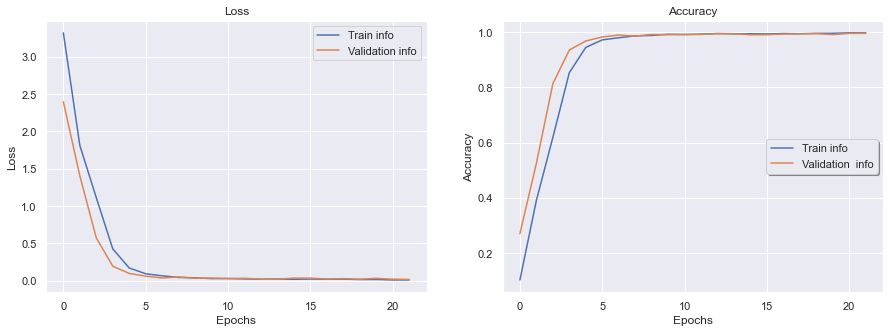

In [26]:
# det the seaborn for better graphics
sb.set()

# sub plots
_, axs = plt.subplots(1, 2, figsize=(15, 5))

### Loss plot 
# make it draw validation loss and training loss
axs[0].plot(train_loss_list, label = "Train info")
axs[0].plot(val_loss_list, label="Validation info")
# set the titles
axs[0].set_title("Loss")
# set the y and x axises
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
guid = axs[0].legend(loc='upper right', shadow=False)

### Accuracy plot
# maske it validation and training accuracy
axs[1].plot(train_acc_list, label = "Train info")
axs[1].plot(val_acc_list, label = "Validation  info")
# set the titles
axs[1].set_title("Accuracy")
# set the y and x axises
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
guid = axs[1].legend(loc='center right', shadow=True)

# save the plot
plt.savefig("accuracy-loss.png", bbox_inches = 'tight', pad_inches=0.5)